# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [ ]:
%%capture
%pip install --user missingno
%pip install --user modin[all]

In [3]:
# import libraries here; add more as necessary
import numpy as np
# import pandas as pd
import os
os.environ["MODIN_ENGINE"] = "ray"
# os.environ["MODIN_ENGINE"] = "dask"
import modin.pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import inspect
import seaborn as sns
from IPython.display import display as idisplay
# import sys, traceback
from pprint import pprint
%matplotlib inline

display = lambda df: idisplay((df._to_pandas() if 'modin.pandas' in str(type(df)) else df))
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None, "display.max_columns", None)

feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

def categorize_binary_features(cleaned_df):
    """
    NOTE: If the dataframe hasn't been scrubbed of encoded "nulls"
    then this will miscategorize binary variables.
    """
    feat_info.loc[feat_info.attribute.isin(
        [c for c in list(cleaned_df) if cleaned_df[c].nunique() == 2]), 'type'] = 'binary'
    
    return cleaned_df


def cols_by_type(type_name, subset_of_columns=None):
    if not subset_of_columns:
        cols = feat_info.attribute.tolist()
    else:
        cols = subset_of_columns

    return [col for col in feat_info[feat_info.type == type_name].attribute.tolist()
            if col in cols]

def print_types():
    sep = '*' * 15
    pprint({f'{sep} << {t} >> {sep}': cols_by_type(t) for t in feat_info.type.unique()})


def __to_pd(df):
    return df._to_pandas() if 'modin.pandas' in str(type(df)) else df

def engineer_new_features(df):
    try:
        df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].map(
            {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4,
             9: 4, 0: 5, 1: 5, 2: 5, 3: 5, 4: 6, 5: 6, })
    except KeyError:
        print('PRAEGENDE_JUGENDJAHRE not present in the dataframe')

    try:
        df['CAMEO_INTL_2015_1'] = df['CAMEO_INTL_2015'].str.slice(start=0, stop=1).astype('float64')
        df['CAMEO_INTL_2015_2'] = df['CAMEO_INTL_2015'].str.slice(start=1, stop=2).astype('float64')
        df = df.drop('CAMEO_INTL_2015', axis=1)
    except KeyError:
        print('CAMEO_INTL_2015 not present in the dataframe')

    try:
        df.OST_WEST_KZ = df['OST_WEST_KZ'].map({'O':0.0, 'W':1.0})
    except KeyError:
        print('OST_WEST_KZ not present in the dataframe')
    
    try: 
        df.CAMEO_DEUG_2015 = df['CAMEO_DEUG_2015'].astype('float')
    except (ValueError, KeyError):
        print('CAMEO_DEUG_2015 not present in the dataframe')    
        
    try: 
        df = df.drop('CAMEO_DEU_2015', axis=1)
    except (ValueError, KeyError):
        print('CAMEO_DEU_2015 not present in the dataframe')
        
    return df

def decode_nans(df):
    feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[]').str.split(',')
    missing_vals = {feat[0]: feat[1]
                    for feat in feat_info[['attribute', 'missing_or_unknown']].values.tolist()}

    ## FILL IN MISSING DATA ACCORDING TO FEATURE INFO DATA
    for c in df.columns:
        df.loc[df[c].isin(missing_vals[c]), c] = np.NaN
    return df

def drop_na_rows(df):
    narows = df.copy()
    narows['cnt'], narows['perc'] = narows.isnull().sum(axis=1), (narows.isnull().sum(axis=1) / len(list(narows)))
    narows = narows[['cnt','perc']]
    narows['above_30_perc'] = narows.perc.apply(lambda x: x > .5)
    df = df.drop(narows[narows['above_30_perc']].index)
    return df

def set_categorical_types(df):
    for col in feat_info[feat_info.type == 'categorical'].attribute.tolist():
        try:
            print(f'Setting {col} as "Categorical" type...')
            df[col] = df[col].astype('category')
        except KeyError as e:
            print(f'\n>> Notice: Missing {col}. Continuing...', '*'*30, '\n\n\n', e)
            pass
    return df

def do_fillna_mode(df):
    """Taken from: 
    https://stackoverflow.com/questions/32617811/
    imputation-of-missing-values-for-categories-in-pandas
    """
    return df.apply(lambda x:x.fillna(x.value_counts().index[0]))

def clean_data(df, get_missing=False):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    # Example taken from: https://www.youtube.com/watch?v=7ZHRM0Fl2S8
    df = df.copy()
    display_missing_data_diff = lambda perc_missing: display(perc_missing)

    perc_missing_before_clean = ((df.isnull().sum() / len(df)).sort_values(ascending=False)) * 100
    df = decode_nans(df)
    perc_missing_after_clean = ((df.isnull().sum() / len(df)).sort_values(ascending=False)) * 100

    # UPDATING DATA TYPES
    df = set_categorical_types(df)
    
    # Remove selected columns...
    df.drop(perc_missing_after_clean[perc_missing_after_clean > 20].index.tolist(), 
            axis=1, inplace=True)

    remaining_cols = df.columns
    perc_missing = pd.concat([perc_missing_before_clean,
                              perc_missing_after_clean], axis=1).reset_index()
    perc_missing.columns = ['Attributes', 'Missing Before', 'Missing After']
    perc_missing['Dropped'] = perc_missing.Attributes.apply(
        lambda x: False if x in remaining_cols else True
    )
    perc_missing = perc_missing.set_index('Attributes')
    
    df = engineer_new_features(df)
    df = categorize_binary_features(df)
    df = drop_na_rows(df)
    df = do_fillna_mode(df)
    
    if get_missing:
        display_missing_data_diff(perc_missing) 
        return df, perc_missing
    else:
        return df

def scale_features(df):
    """Example from:
    https://stackoverflow.com/questions/43798377/
    one-hot-encode-categorical-variables-and-scale-continuous-ones-simultaneouely
    """
    df = df.dropna()
    df = __to_pd(df)

    nums = cols_by_type('numeric', list(df))
    ordinal = cols_by_type('ordinal', list(df))
    cat = cols_by_type('categorical', list(df))
    
    ##Manual Exceptions for Mixed Types
    [ordinal.append(c) for c in ['PLZ8_BAUMAX', 'WOHNLAGE'] if c in list(df)] 
    [cat.append(c) for c in  
        ['ALTERSKATEGORIE_GROB','LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE']
     if c in list(df)
    ]
    
    coltransformer = ColumnTransformer(
        transformers=[
            ('ord', OrdinalEncoder(), ordinal),
            ('num_imputer', SimpleImputer(), nums),
            ('cat_ord_imp', SimpleImputer(
                missing_values=np.nan,
                strategy='most_frequent'), cat+ordinal),
            ('onehot', OneHotEncoder(), cat)
        ],
        remainder='passthrough', #'drop',
        n_jobs=-1)
    
    scaler = StandardScaler()
    scaler.fit_transform(coltransformer.fit_transform(df))

    return scaler

def get_set_pipe(df, params=None):
    if params:        
        pca__n_components = params.get('pca__n_components', None)
        km__n_clusters = params.get('km__n_clusters', None)        
        pca = PCA(pca__n_components) if pca__n_components else PCA()
        km = KMeans(km__n_clusters) if km__n_clusters else KMeans()
    else:
        km, pca = KMeans(), PCA()
        
    return Pipeline(steps=[('prep', scale_features(df)), ('pca', pca), ('km', km)])

def grid_search(df, n_jobs=-1):
    df = __to_pd(df)
    pipe = get_set_pipe(df)
    pipe.fit(df)
    param_grid = {
        'pca__n_components': [5, 15, 30, 45, 64],
        "km__n_clusters": range(2, 11),
    }
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=10)
    search.fit(df)

    return dict(best_score=search.best_score_,
                               best_params=search.best_params_,
                               named_steps=search.best_estimator_.named_steps)

def fit_model_pipe(df, params=None):
    df = __to_pd(df)
    params = grid_search(df, show_only=False) if params is None else params
    km = KMeans(params['km__n_clusters'])
    pca = PCA(params['pca__n_components'])
    transformer = scale_features(df)

    return Pipeline(steps=[('prep', transformer), ('pca', pca), ('km', km)]).fit(df)

def add_missing_dummy_columns(d, columns):
    """TAKEN FROM: https://knowledge.udacity.com/questions/65620"""
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    """TAKEN FROM: https://knowledge.udacity.com/questions/65620"""
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d

print_src = lambda func_name: print(f"""\033[92m\033[94m{inspect.getsource(globals()[func_name])}\033[94m\033[92m""")


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_azdias_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `azdias_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [12]:
%%time
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

CPU times: user 349 ms, sys: 137 ms, total: 486 ms
Wall time: 2.23 s


In [13]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

"""
NOTE: 

I manually call display here because the display function I'm using is shadowing
the default Juptyer display function and has special 
functionality to handle a known bug with Jupyter displaying Modin dataframes
"""

display(azdias.head())
display(feat_info.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

### Step 1.1 & Step 1.1.1 (SOLUTIONS): Assess Missing Data

In [14]:
%%time
display(feat_info.head(n=10))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


CPU times: user 16.6 ms, sys: 1.9 ms, total: 18.5 ms
Wall time: 21.8 ms


In [15]:
%%time
# Perform an assessment of how much missing data there is in each column of the dataset. 

# Correctly converts encodings for missing data to NaNs
# Then Removes Rows / Columns of missing data and updates dtypes

azdias_cleaned, perc_missing =  clean_data(azdias, get_missing=True) #View source code with print_src('clean_data')
## ALSO DISPLAY MISSING DATA

Setting AGER_TYP as "Categorical" type...
Setting ANREDE_KZ as "Categorical" type...
Setting CJT_GESAMTTYP as "Categorical" type...
Setting FINANZTYP as "Categorical" type...
Setting GFK_URLAUBERTYP as "Categorical" type...
Setting GREEN_AVANTGARDE as "Categorical" type...
Setting LP_FAMILIE_FEIN as "Categorical" type...
Setting LP_FAMILIE_GROB as "Categorical" type...
Setting LP_STATUS_FEIN as "Categorical" type...
Setting LP_STATUS_GROB as "Categorical" type...
Setting NATIONALITAET_KZ as "Categorical" type...
Setting SHOPPER_TYP as "Categorical" type...
Setting SOHO_KZ as "Categorical" type...
Setting TITEL_KZ as "Categorical" type...
Setting VERS_TYP as "Categorical" type...
Setting ZABEOTYP as "Categorical" type...
Setting KK_KUNDENTYP as "Categorical" type...
Setting GEBAEUDETYP as "Categorical" type...
Setting OST_WEST_KZ as "Categorical" type...
Setting CAMEO_DEUG_2015 as "Categorical" type...
Setting CAMEO_DEU_2015 as "Categorical" type...
(pid=23935) /Library/edb/languagepack

,Missing Before,Missing After,Dropped
Attributes,,,
AGER_TYP,0.000000,76.955435,True
ALTERSKATEGORIE_GROB,0.000000,0.323264,False
ALTER_HH,8.247000,34.813699,True
ANREDE_KZ,0.000000,0.000000,False
ANZ_HAUSHALTE_AKTIV,10.451729,11.176913,False
ANZ_HH_TITEL,10.884842,10.884842,False
ANZ_PERSONEN,8.247000,8.247000,False
ANZ_TITEL,8.247000,8.247000,False
ARBEIT,10.908181,10.926022,False


CPU times: user 1min 15s, sys: 6.9 s, total: 1min 22s
Wall time: 2min 28s


CPU times: user 220 ms, sys: 39.3 ms, total: 259 ms
Wall time: 291 ms


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


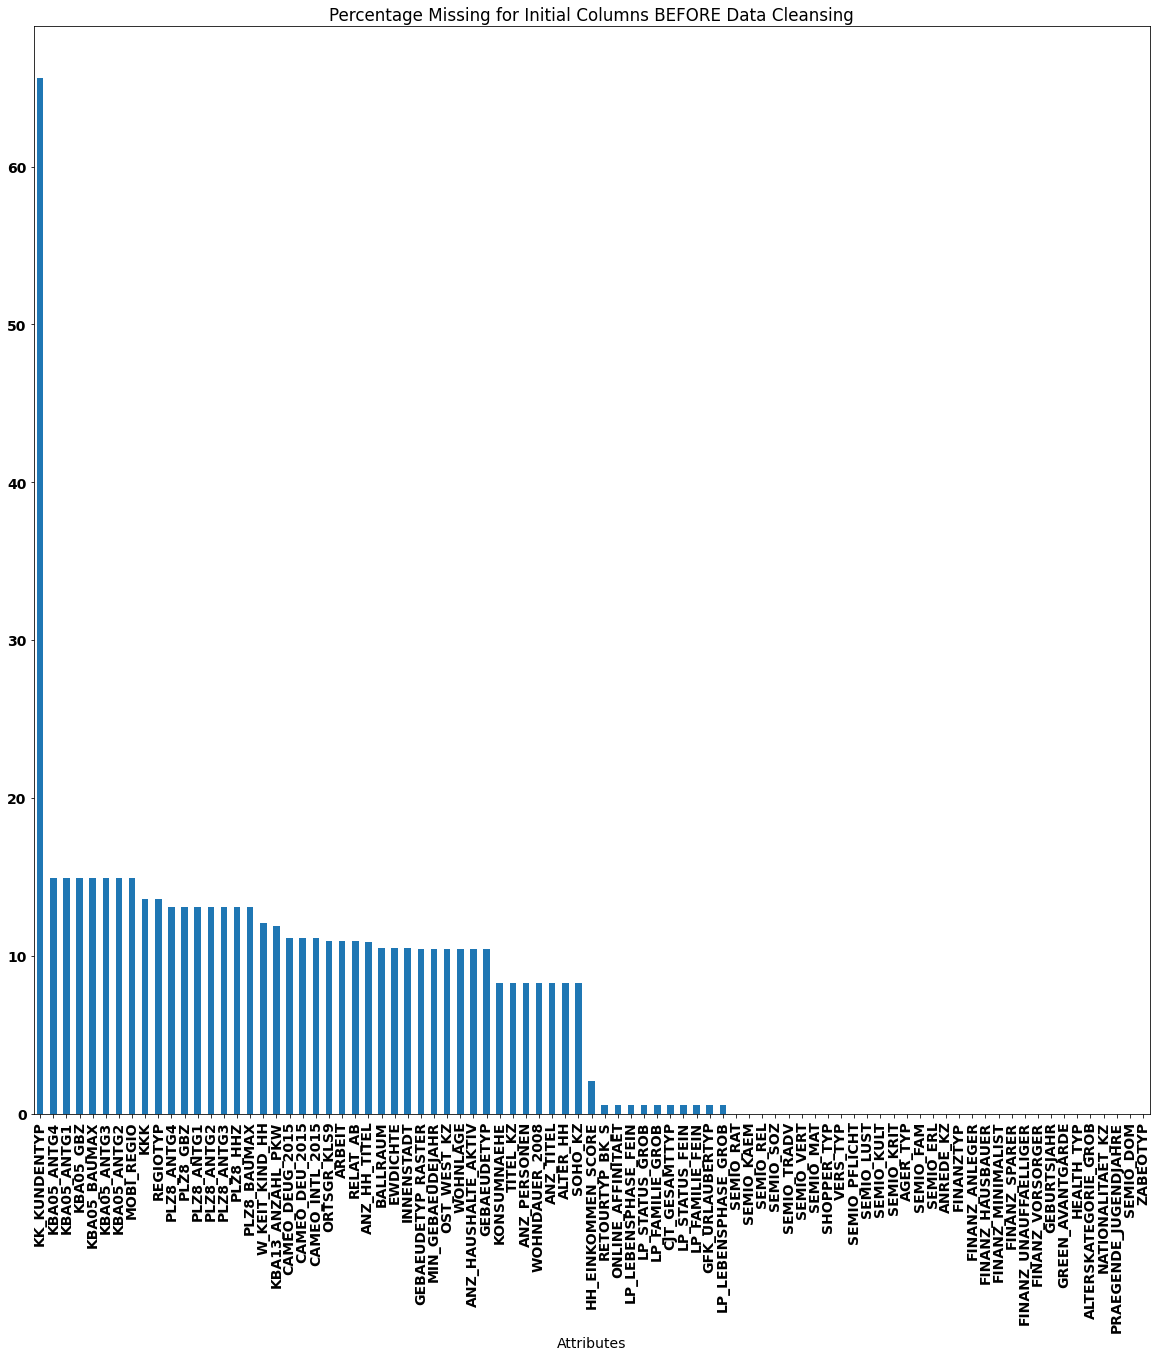

In [16]:
%%time
# Investigate patterns in the amount of missing data in each column.
# # msno.bar(azdias) 
# msno.heatmap(azdias)

# plt.figure(figsize=(20,20))
# sns.heatmap(azdias.isnull(), cbar=False)
"""
Formatting how-to taken from:
https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
"""

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(20,20))
plt.title('Percentage Missing for Initial Columns BEFORE Data Cleansing')
perc_missing['Missing Before'].sort_values(ascending=False).plot.bar()

CPU times: user 189 ms, sys: 16.8 ms, total: 206 ms
Wall time: 218 ms


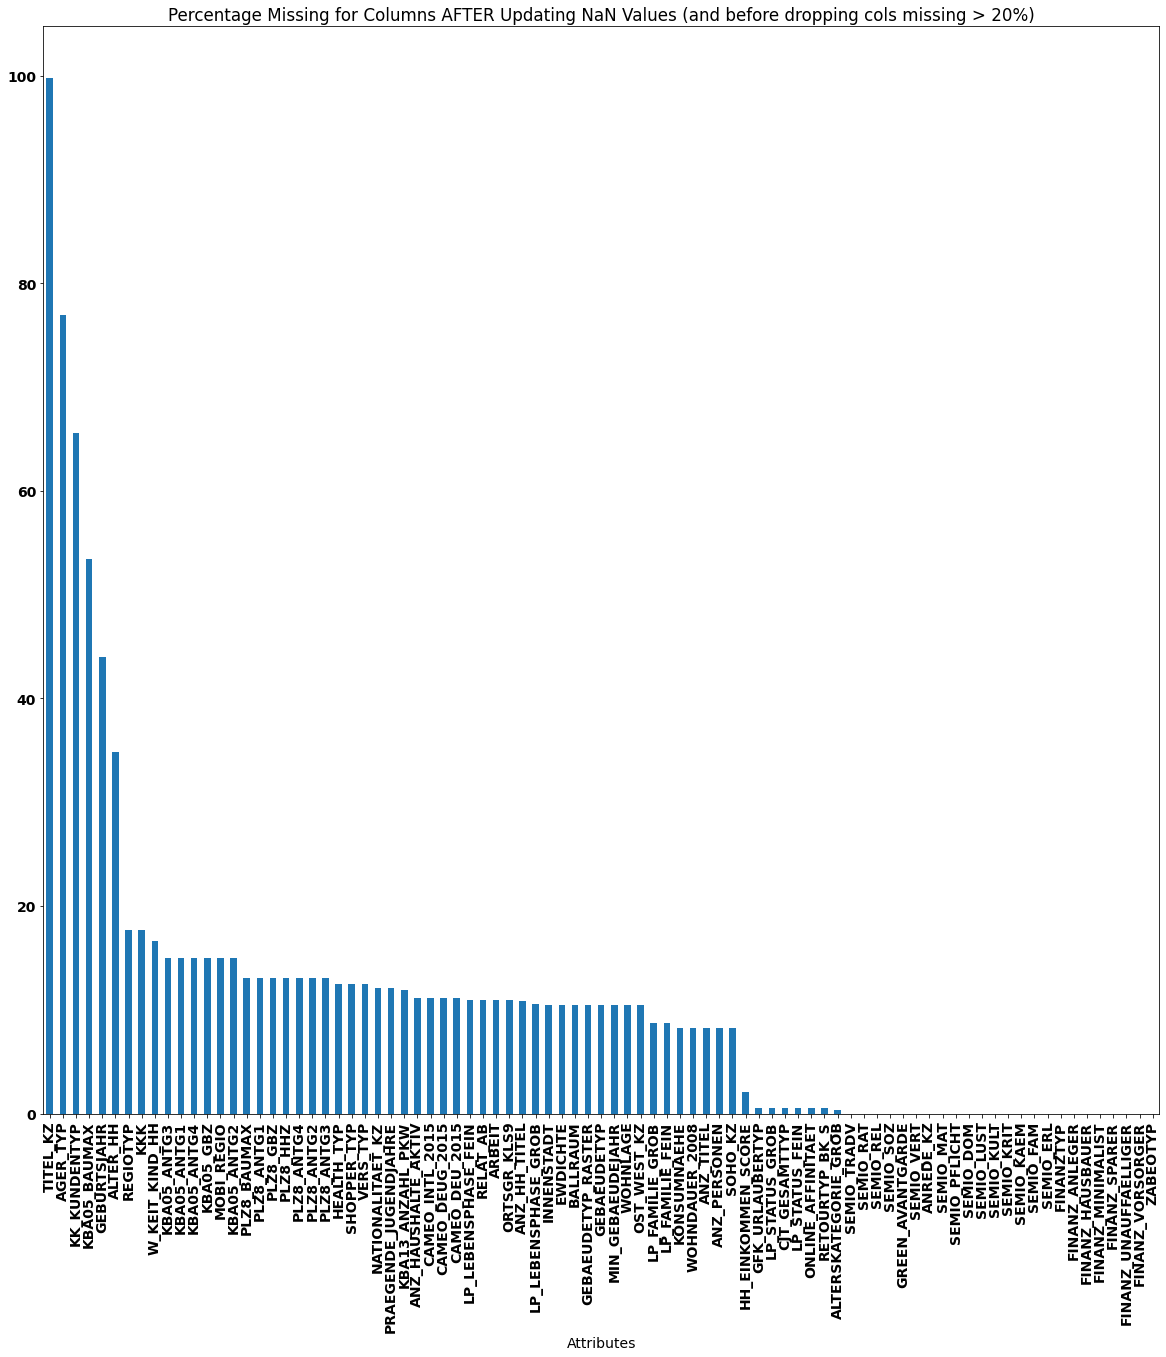

In [17]:
%%time
# Investigate patterns in the amount of missing data in each column.
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(20,20))
plt.title('Percentage Missing for Columns AFTER Updating NaN Values (and before dropping cols missing > 20%)')
perc_missing['Missing After'].sort_values(ascending=False).plot.bar()

CPU times: user 181 ms, sys: 19.5 ms, total: 200 ms
Wall time: 225 ms


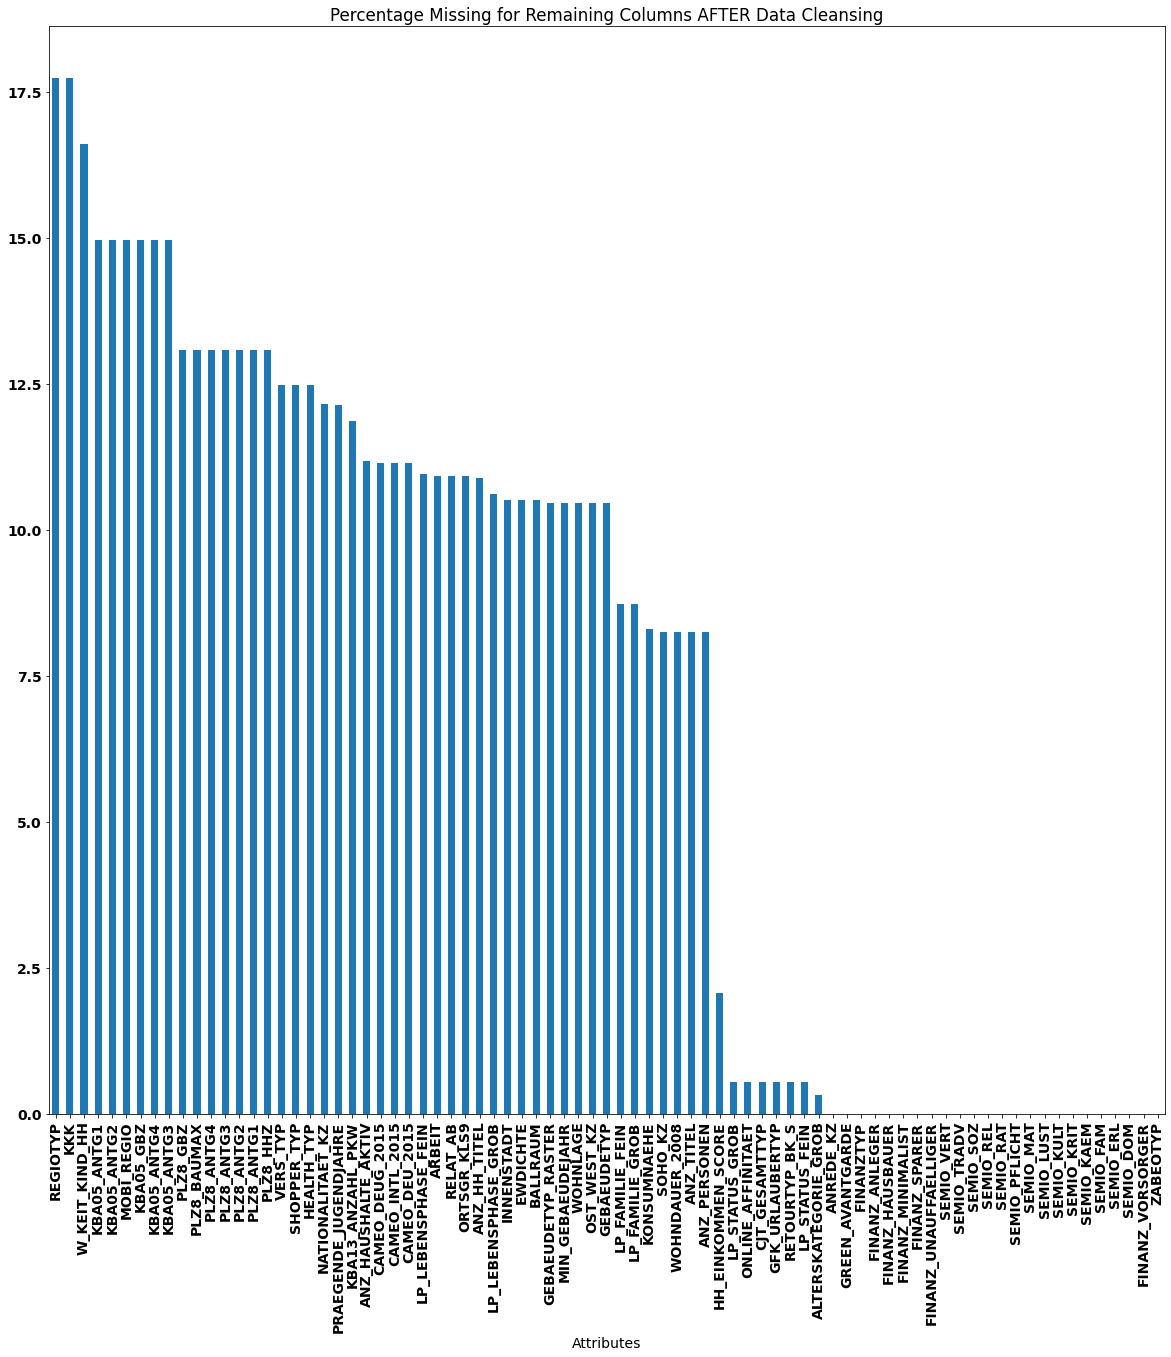

In [18]:
%%time
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(20,20))
plt.title('Percentage Missing for Remaining Columns AFTER Data Cleansing')
perc_missing.query('Dropped == False')['Missing After'].sort_values(ascending=False).plot.bar()

In [19]:
%%time
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Rule of thumb is more than 20% of missing data can throw off analysis

"""
NOTE: Outlier Columns were already removed via the "clean_data" method previously.
See source code before.
"""
print_src('clean_data')

def clean_data(df, get_missing=False):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    # Example taken from: https://www.youtube.com/watch?v=7ZHRM0Fl2S8
    df = df.copy()
    display_missing_data_diff = lambda perc_missing: display(perc_missing)

    perc_missing_before_clean = ((df.isnull().sum() / len(df)).sort_values(ascending=False)) * 100
    df = decode_nans(df)
    perc_missing_after_clean = ((df.isnull().sum() / len(df)).sort_values(ascending=False)) * 100

    # UPDATING DATA TYPES
    df = set_categorical_types(df)
    
    # Remove selected columns...
    df.drop(perc_missing_after_clean[perc_missing_after_clean > 20].index.tolist(), 
            axis=1, inplace=True)

    remaining_cols = df.columns
    perc_missing = pd.conc

In [20]:
sep = '='*60
print(f'{sep}\nDROPPED Columns:\n{sep}')
display(perc_missing.query('Dropped == True'))

DROPPED Columns:


,Missing Before,Missing After,Dropped
Attributes,,,
AGER_TYP,0.000000,76.955435,True
ALTER_HH,8.247000,34.813699,True
GEBURTSJAHR,0.000000,44.020282,True
KBA05_BAUMAX,14.959701,53.468668,True
KK_KUNDENTYP,65.596749,65.596749,True
TITEL_KZ,8.247000,99.757636,True


#### Discussion 1.1.2: Assess Missing Data in Each Column

The initial set of missing data was misleading. Decoding the "missing values" as were specified in the accompanying documents lead me to understand that 
many features contained a significant amount more missing data than I assumed from first glance. It rendered a handful of features useless.

These are the dropped columns missing > 20%: AGER_TYP, ALTER_HH, GEBURTSJAHR, KBA05_BAUMAX, KK_KUNDENTYP, and TITEL_KZ.
    
"TITEL_KZ" in particular went from ~8% to ~99% null after accounting for encoded values.
This makes sense when looking at the data dictionary. Most people do not have title specifying academic acheivement (like Dr. or Prof.). It could have been recoded for having and not-having an honorific title, but the remaining number of entries likely wouldn't reveal a significant trend. If it did, then specific titles are likely correlated with household income which would be a better overall predictor in general.

GEBURTSJAHR (year of birth) is intuitively an important feature. If this data is not present or useable, I would suggest that the company attempt to collect this data by other direct or indirect means if it can't be inferred from other, existing features.

Per each feature, it would be wise to classify missing data trends as Missing at Random, Missing Completely at Random, Missing Not at Random, etc.. 

Reference -- https://towardsdatascience.com/all-about-missing-data-handling-b94b8b5d2184

For the other columns, I am either not familiar with the terminology used enough to apply any significant meaning (i.e. not sure what microcell and passive elderly) or the terms seem value or subjective. For instance, head of household is an ambiguous and/or culturally outdated term. It could signify the top fiscal earner or father in traditional nuclear family, but may not apply to dual-income egalitarian households.

For remaining columns with a high percent of missing values, I'd want to find out if there is an underlying reason, which may influence my decision to impute vs. drop.  

This does raise the importance of understanding the underlying data and how its collected and having insight into the business domain.
On its surface this seems like an obvious thing to point out, but I have seen plenty of case where people try to niavely throw algorithms, tools, etc.. at data expecting it to yield value.
It is vitally important to sit down with subject matter experts, data entry personnel, and long-time exmployees who understand how encoded data changes over time.
This dataset comes with a data dictionary that spells it out for you, but in the real world one might have to go digging to find encoded data that should be NULL to eliminate
dummy records. Spending weeks or months interviewing data and business process owners is tedious. The tendency is for data practioners to skip straight to modeling  either due to
pure negligence or environmental stressors such as impatient business stakeholders.

Apart from this excersise, its also very important to understand WHY certain data is missing. Sometimes missing data gives insights into a business process and can yield
additional features in its own right. If this were a real-world scenario, I would be inclined to ask business users why certain features are almost entirely empty.

Some example business questions might be:
    - Did we just recently start collecting that data? 
    - Is there something about specific populations that would lead to omissions? 
    - Is this data volitioning provided by customers and if so can we infer any additional customer behaviors 
    from their desire to abstain from answering particular survey questions?

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# %%time
# corrs = azdias.isnull().corr()
# corrs.abs().mean().sort_values(ascending=False)
# # corrs.plot(figsize=(30,30))
# corrs.style.background_gradient(cmap='coolwarm', axis=None)

In [22]:
%%time
# How much data is missing in each row of the dataset?
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

narows = pd.read_csv('Udacity_AZDIAS_Subset.csv', ';')
narows = decode_nans(narows)
# narows = azdias.copy(); del azdias 

narows['cnt'], narows['perc'] = narows.isnull().sum(axis=1), (narows.isnull().sum(axis=1) / len(list(narows)))
narows = narows[['cnt','perc']]
narows['above_30_perc'] = narows.perc.apply(lambda x: x > .3)
display(narows.sort_values(by='perc', ascending=False).head(n=10))

,cnt,perc,above_30_perc
732775,54,0.635294,True
582372,53,0.623529,True
33158,53,0.623529,True
167341,53,0.623529,True
56204,53,0.623529,True
99965,53,0.623529,True
812953,53,0.623529,True
507593,53,0.623529,True
812946,53,0.623529,True
507607,53,0.623529,True


CPU times: user 27.9 s, sys: 2.26 s, total: 30.2 s
Wall time: 49.3 s


In [23]:
summary = narows.sort_values(by='perc', ascending=False)
summary = summary.cnt.value_counts().reset_index()
summary.columns = ['num_missing', 'row_count']
display(summary.sort_values(by='num_missing'))

,num_missing,row_count
39,0,143
6,1,30377
1,2,135292
0,3,189850
2,4,133473
3,5,110108
4,6,71615
8,7,17502
9,8,16808
10,9,15432


In [24]:
display(pd.DataFrame(narows['above_30_perc'].value_counts() / len(narows))
        .rename(columns={0:'Above 30 Percent Missing Fields'}))

,Above 30 Percent Missing Fields
False,0.89471
True,0.10529


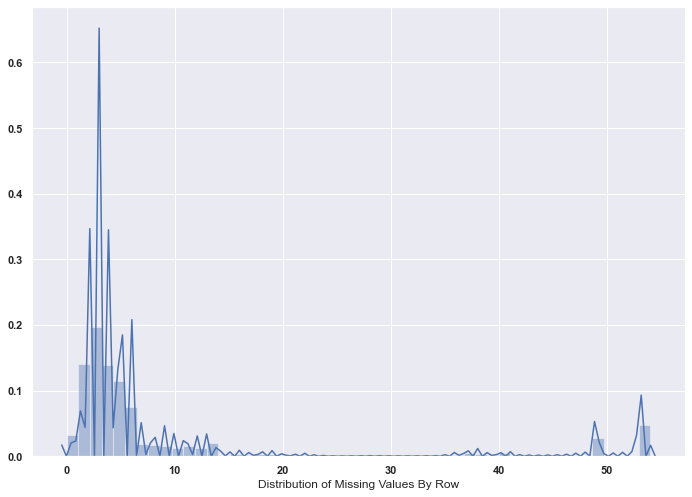

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(narows['cnt'], axlabel='Distribution of Missing Values By Row')

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
"""
I HAVE NO IDEA WHAT THIS IS ASKING!

Aren't we discussing rows and not columns here??
"""

"\nI HAVE NO IDEA WHAT THIS IS ASKING!\n\nAren't we discussing rows and not columns here??\n"

In [29]:
# Function to drop NA Rows
print_src('drop_na_rows')

def drop_na_rows(df):
    narows = df.copy()
    narows['cnt'], narows['perc'] = narows.isnull().sum(axis=1), (narows.isnull().sum(axis=1) / len(list(narows)))
    narows = narows[['cnt','perc']]
    narows['above_30_perc'] = narows.perc.apply(lambda x: x > .5)
    df = df.drop(narows[narows['above_30_perc']].index)
    return df



#### Discussion 1.1.3: Assess Missing Data in Each Row

It appears for the most part that the vast majority of rows with missing data fall under a threshold of about 20% or so of fields missing while there are a small number where most of the fields are missing.

In summary from looking at the distribution, it seems to be either/or -- i.e. either under 20 or nearly all fields containing NaN values. 

I believe that the small number of mostly NaN records can be safely dropped while the remaining null values can be successfully imputed. This allows us to retain the bulk of records. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
%%time
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Re-encode categorical variable(s) to be kept in the analysis.
'Categorical (Binary too), and Ordinal features need to be re-encoded'

"""I created a series of functions for these purposes"""

print_src('categorize_binary_features')
print_src('engineer_new_features')
print_src('set_categorical_types')
print_src('print_types')

def categorize_binary_features(cleaned_df):
    """
    NOTE: If the dataframe hasn't been scrubbed of encoded "nulls"
    then this will miscategorize binary variables.
    """
    feat_info.loc[feat_info.attribute.isin(
        [c for c in list(cleaned_df) if cleaned_df[c].nunique() == 2]), 'type'] = 'binary'
    
    return cleaned_df

def engineer_new_features(df):
    try:
        df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].map(
            {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4,
             9: 4, 0: 5, 1: 5, 2: 5, 3: 5, 4: 6, 5: 6, })
    except KeyError:
        print('PRAEGENDE_JUGENDJAHRE not present in the dataframe')

    try:
        df['CAMEO_INTL_2015_1'] = df['CAMEO_INTL_2015'].str.slice(start=0, stop=1).astype('float64')
        df['CAMEO_INTL_2015_2'] = df['CAMEO_INTL_2015'].str.slice(start=1, stop=2).astype('float64')
        df = df.drop('CAMEO_INTL_2015', axis=1)
    except KeyError:
        print('CAMEO_INTL_2015 not present in the dataframe

In [31]:
print_types()

{'*************** << binary >> ***************': ['ANREDE_KZ',
                                                  'GREEN_AVANTGARDE',
                                                  'SOHO_KZ',
                                                  'VERS_TYP',
                                                  'OST_WEST_KZ'],
 '*************** << categorical >> ***************': ['AGER_TYP',
                                                       'CJT_GESAMTTYP',
                                                       'FINANZTYP',
                                                       'GFK_URLAUBERTYP',
                                                       'LP_FAMILIE_FEIN',
                                                       'LP_FAMILIE_GROB',
                                                       'LP_STATUS_FEIN',
                                                       'LP_STATUS_GROB',
                                                       'NATIONALITAET_KZ',
                            

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# FROM DATA_DICTIONARY
"""Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)"""

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# FROM DATA_DICTIONARY
"""German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown"""


#NOTE: This was already called in the "clean_data()" method
print_src('engineer_new_features')

def engineer_new_features(df):
    try:
        df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].map(
            {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4,
             9: 4, 0: 5, 1: 5, 2: 5, 3: 5, 4: 6, 5: 6, })
    except KeyError:
        print('PRAEGENDE_JUGENDJAHRE not present in the dataframe')

    try:
        df['CAMEO_INTL_2015_1'] = df['CAMEO_INTL_2015'].str.slice(start=0, stop=1).astype('float64')
        df['CAMEO_INTL_2015_2'] = df['CAMEO_INTL_2015'].str.slice(start=1, stop=2).astype('float64')
        df = df.drop('CAMEO_INTL_2015', axis=1)
    except KeyError:
        print('CAMEO_INTL_2015 not present in the dataframe')

    try:
        df.OST_WEST_KZ = df['OST_WEST_KZ'].map({'O':0.0, 'W':1.0})
    except KeyError:
        print('OST_WEST_KZ not present in the dataframe')
    
    try: 
        df.CAMEO_DEUG_2015 = df['CAMEO_DEUG_2015'].astype('float')
    except (ValueError, KeyError):
        print('CAMEO_DEUG_2015 not present in the dataframe')    

#### Discussion 1.2.2: Engineer Mixed-Type Features

For the mixed types I split some into multiple variables and others I just dropped as the multiple values would have been difficult to encode and that info seemed to be captured in other variables already. 

The function "engineer_new_features" above shows which features I chose to re-encode with mapped values, which ones I chose to to split into multiple features, and which ones I dropped entirely.

- CAMEO_INTL_2015 was split into 2 features 
- CAMEO_DEU_2015 was dropped as CAMEO_DEUG_2015 contains similar information.
- OST_WEST_KZ and PRAEGENDE_JUGENDJAHRE were re-mapped

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [34]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

"""
NOTE:
This will be done with the scale_features function with the 
remainder='drop' transformer step"
"""

print_src('scale_features')

def scale_features(df):
    """Example from:
    https://stackoverflow.com/questions/43798377/
    one-hot-encode-categorical-variables-and-scale-continuous-ones-simultaneouely
    """
    df = df.dropna()
    df = __to_pd(df)

    nums = cols_by_type('numeric', list(df))
    ordinal = cols_by_type('ordinal', list(df))
    cat = cols_by_type('categorical', list(df))
    
    ##Manual Exceptions for Mixed Types
    [ordinal.append(c) for c in ['PLZ8_BAUMAX', 'WOHNLAGE'] if c in list(df)] 
    [cat.append(c) for c in  
        ['ALTERSKATEGORIE_GROB','LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE']
     if c in list(df)
    ]
    
    coltransformer = ColumnTransformer(
        transformers=[
            ('ord', OrdinalEncoder(), ordinal),
            ('num_imputer', SimpleImputer(), nums),
            ('cat_ord_imp', SimpleImputer(
                missing_values=np.nan,
                strategy='most_frequent'), cat+ordinal),
            ('onehot', OneHotEncoder(),

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [35]:
%%time 
print_src('clean_data')

def clean_data(df, get_missing=False):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    # Example taken from: https://www.youtube.com/watch?v=7ZHRM0Fl2S8
    df = df.copy()
    display_missing_data_diff = lambda perc_missing: display(perc_missing)

    perc_missing_before_clean = ((df.isnull().sum() / len(df)).sort_values(ascending=False)) * 100
    df = decode_nans(df)
    perc_missing_after_clean = ((df.isnull().sum() / len(df)).sort_values(ascending=False)) * 100

    # UPDATING DATA TYPES
    df = set_categorical_types(df)
    
    # Remove selected columns...
    df.drop(perc_missing_after_clean[perc_missing_after_clean > 20].index.tolist(), 
            axis=1, inplace=True)

    remaining_cols = df.columns
    perc_missing = pd.conc

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [37]:
%%time
# Apply featurea scaling to the general population demographics data.
transformer = scale_features(azdias_cleaned)

CPU times: user 33.8 s, sys: 36.9 s, total: 1min 10s
Wall time: 2min 11s


In [38]:
print_src('scale_features')

def scale_features(df):
    """Example from:
    https://stackoverflow.com/questions/43798377/
    one-hot-encode-categorical-variables-and-scale-continuous-ones-simultaneouely
    """
    df = df.dropna()
    df = __to_pd(df)

    nums = cols_by_type('numeric', list(df))
    ordinal = cols_by_type('ordinal', list(df))
    cat = cols_by_type('categorical', list(df))
    
    ##Manual Exceptions for Mixed Types
    [ordinal.append(c) for c in ['PLZ8_BAUMAX', 'WOHNLAGE'] if c in list(df)] 
    [cat.append(c) for c in  
        ['ALTERSKATEGORIE_GROB','LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE']
     if c in list(df)
    ]
    
    coltransformer = ColumnTransformer(
        transformers=[
            ('ord', OrdinalEncoder(), ordinal),
            ('num_imputer', SimpleImputer(), nums),
            ('cat_ord_imp', SimpleImputer(
                missing_values=np.nan,
                strategy='most_frequent'), cat+ordinal),
            ('onehot', OneHotEncoder(),

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [4]:
%%time
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', ';')
azdias_cleaned = clean_data(azdias)
azdias_cleaned.head()
# azdias_cleaned.to_csv('azdias_cleaned.csv', index=False)

Setting AGER_TYP as "Categorical" type...
Setting ANREDE_KZ as "Categorical" type...
Setting CJT_GESAMTTYP as "Categorical" type...
Setting FINANZTYP as "Categorical" type...
Setting GFK_URLAUBERTYP as "Categorical" type...
Setting GREEN_AVANTGARDE as "Categorical" type...
Setting LP_FAMILIE_FEIN as "Categorical" type...
Setting LP_FAMILIE_GROB as "Categorical" type...
Setting LP_STATUS_FEIN as "Categorical" type...
Setting LP_STATUS_GROB as "Categorical" type...
Setting NATIONALITAET_KZ as "Categorical" type...
Setting SHOPPER_TYP as "Categorical" type...
Setting SOHO_KZ as "Categorical" type...
Setting TITEL_KZ as "Categorical" type...
Setting VERS_TYP as "Categorical" type...
Setting ZABEOTYP as "Categorical" type...
Setting KK_KUNDENTYP as "Categorical" type...
Setting GEBAEUDETYP as "Categorical" type...
Setting OST_WEST_KZ as "Categorical" type...
Setting CAMEO_DEUG_2015 as "Categorical" type...
Setting CAMEO_DEU_2015 as "Categorical" type...
(pid=1270) /Library/edb/languagepack/

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,2.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,3.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,5.0,4.0


In [5]:
%%time
pipe = get_set_pipe(azdias_cleaned)
pca = pipe.steps[1][1]
pca.fit(scale_features(azdias_cleaned).fit_transform(azdias_cleaned))

(pid=1400) /Library/edb/languagepack/v1/Python-3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=1400)   warnings.warn(msg)
(pid=1393) /Library/edb/languagepack/v1/Python-3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=1393)   warnings.warn(msg)
(pid=1397) /Library/edb/languagepack/v1/Python-3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=1397)   warnings.warn(msg)
(pid=1399) /Library/edb/languagepack/v1/Python-3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: C

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [6]:
%%time
# grid_search_results = dict(best_params=dict(km__n_clusters=10, pca__n_components=5))
# grid_search_results = grid_search(azdias_cleaned.dropna())
grid_search_results = grid_search(azdias_cleaned, n_jobs=4)
# pickle.dump(grid_search_results, open("grid_search_results.pkl", "wb"))
grid_search_results['best_params']

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 52.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 53.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 57.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 67.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 76.8min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 88.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 95.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 101.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 110.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 129.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed

CPU times: user 8min 43s, sys: 2min 35s, total: 11min 18s
Wall time: 2h 38min 36s


{'km__n_clusters': 10, 'pca__n_components': 5}

In [7]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_.round(2)

array([1.347e+01, 8.770e+00, 6.270e+00, 4.590e+00, 3.180e+00, 2.310e+00,
       2.100e+00, 1.900e+00, 1.710e+00, 1.540e+00, 1.520e+00, 1.410e+00,
       1.320e+00, 1.240e+00, 1.180e+00, 1.110e+00, 1.030e+00, 1.000e+00,
       9.600e-01, 9.300e-01, 9.200e-01, 9.000e-01, 8.800e-01, 8.400e-01,
       8.100e-01, 7.800e-01, 7.800e-01, 7.300e-01, 7.200e-01, 7.100e-01,
       6.700e-01, 6.400e-01, 6.000e-01, 5.700e-01, 5.300e-01, 4.900e-01,
       4.900e-01, 4.700e-01, 4.600e-01, 4.600e-01, 4.400e-01, 4.200e-01,
       4.100e-01, 3.900e-01, 3.700e-01, 3.600e-01, 3.400e-01, 3.100e-01,
       3.000e-01, 2.900e-01, 2.800e-01, 2.700e-01, 2.600e-01, 2.500e-01,
       2.400e-01, 2.400e-01, 2.300e-01, 2.200e-01, 2.100e-01, 2.000e-01,
       2.000e-01, 1.900e-01, 1.700e-01, 1.700e-01, 1.500e-01, 1.400e-01,
       1.400e-01, 1.300e-01, 1.200e-01, 1.200e-01, 1.000e-01, 1.000e-01,
       8.000e-02, 5.000e-02, 5.000e-02, 4.000e-02, 1.000e-02, 1.000e-02,
       1.000e-02])

In [ ]:
%%time
# Re-apply PCA to the data while selecting for number of components to retain.
n_clust, n_comps = grid_search_results['best_params'].values()
pca = PCA(n_components=n_comps)
scaler = scale_features(azdias_cleaned)
pca = pca.fit(scaler.fit_transform(azdias_cleaned))

"""
NOTE: This is already done via fit_model_pipe method.
It runs the grid_search method
""" 
print_src('fit_model_pipe')    
print_src('scale_features')

### Discussion 2.2: Perform Dimensionality Reduction

The custom grid_search function I created indicates that 5 components is a good number, so that what I chose for that parameter in PCA.

As you can see in the "scale_features" function, I chose to scale the features separately using a pipeline of ColumnTransformers and then passed all to the StandardScaler according to their data types in the feat_info dataframe -- e.g. ordinal, numerical, and categorical.

I was able to encode and keep the majority of features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [9]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# cust.pca.fit(cust_df)
sort_pca = lambda comp_num : [f'{i[0]}\t{i[1]}'.expandtabs(30) 
                              for i in sorted(
                                  {k:v for k,v in zip(azdias_cleaned.columns, pca.components_[comp_num])}.items(),
                                  key=lambda x: x[1]
                              )]
sep = '*'*60
print(f'{sep}\n<< FIRST PRINCIPLE COMPONENT VALUES >>\n{sep}')
sort_pca(0)

************************************************************
<< FIRST PRINCIPLE COMPONENT VALUES >>
************************************************************


NameError: name 'azdias_cleaned' is not defined

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(f'{sep}\n<< SECOND PRINCIPLE COMPONENT VALUES >>\n{sep}')
sort_pca(1)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(f'{sep}\n<< THIRD PRINCIPLE COMPONENT VALUES >>\n{sep}') 
sort_pca(2)

In [ ]:
print(f'{sep}\n<< FOURTH PRINCIPLE COMPONENT VALUES >>\n{sep}') 
sort_pca(3)

In [ ]:
print(f'{sep}\n<< FIFTH PRINCIPLE COMPONENT VALUES >>\n{sep}') 
sort_pca(4)

### Discussion 2.3: Interpret Principal Components

One can see above which features are most important in terms of separation PCA components. I'm not sure exactly how to interpret this as I struggled to align features to components to clusters. As far as I can see, this shows which features segment the populations, but I'm not sure what a quintessential customer for each cluster would look like exactly precisely.

This might be out of scope, but it seems that PCA is not an ideal tool for market segmentation specifically.

- Explanation -- PCA helps reduce noise and is likely optimal if a Data Scientist is trying to PREDICT clusters (for use cases such as recommendation engines), but it is not optimal for understanding markets as PCA adds a level of opacity to the analysis.

I believe reasons such as this have been described as a particular reason NOT to use Principal Component Analysis.

As a newbie in this area, I am somewhat stumped in terms of interpretation whereas I would have little difficulty implementing this for the goal of prediction.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [2]:
%%time
# grid_search_results = dict(best_params=dict(km__n_clusters=10, pca__n_components=5))
# azdias_cleaned = clean_data(pd.read_csv('Udacity_AZDIAS_Subset.csv', ';'))
# azdias_cleaned.to_csv('azdias_cleaned.csv', sep=';', index=False)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.72 µs


In [3]:
# azdias_cleaned.to_csv('azdias_cleaned.csv', sep=';', index=False)
azdias_cleaned = pd.read_csv('azdias_cleaned.csv', sep=';')

In [44]:
%%time
"""
Over a number of different cluster counts...
Compute the average within-cluster distances.
Run k-means clustering on the data and...
"""
pca_n_comps = grid_search_results['best_params']['pca__n_components']
scaled = scale_features(azdias_cleaned).fit_transform(azdias_cleaned)
# scores = pd.DataFrame([(n_clusters, 
#                         np.abs(get_set_pipe(df=azdias_cleaned, params=dict(
#                                             pca__n_components=pca_n_comps, 
#                                             km__n_clusters=n_clusters))
#                                .fit(scaled) #.steps[2][1].inertia_
#                                .score(azdias_cleaned))) 
#         for n_clusters in range(1, 25)],
#     columns=['n_clusters', 'score'])

scores = pd.DataFrame(columns=['n_clusters', 'score'])
for n_clusters in range(1, 25):
    print(f'Cluster #{str(n_clusters)}')
    params=dict(pca__n_components=pca_n_comps, km__n_clusters=n_clusters)
    fit_score = np.abs(get_set_pipe(df=azdias_cleaned, params=params).fit(scaled).score(azdias_cleaned))
    scores = scores.append(pd.DataFrame([(n_clusters, fit_score)], columns=['n_clusters', 'score']))


Cluster #1
Cluster #2
Cluster #3
Cluster #4
Cluster #5
Cluster #6
Cluster #7
Cluster #8
Cluster #9
Cluster #10
Cluster #11
Cluster #12
Cluster #13
Cluster #14
Cluster #15
Cluster #16
Cluster #17
Cluster #18
Cluster #19
Cluster #20
Cluster #21
Cluster #22
Cluster #23
Cluster #24
CPU times: user 38min 19s, sys: 9min 16s, total: 47min 36s
Wall time: 43min 51s


In [45]:
pickle.dump(scores, open("scores.pkl", "wb"))
# scores = pickle.load(open('scores.pkl', 'rb'))

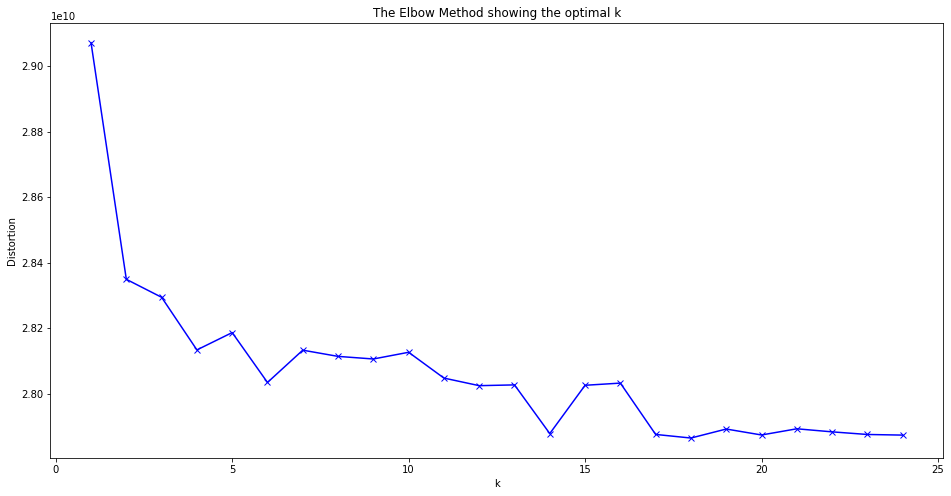

In [47]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Example taken from: https://predictivehacks.com/k-means-elbow-method-code-for-python/
plt.figure(figsize=(16,8))
plt.plot(list(scores.n_clusters), scores.score, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [48]:
grid_search_results['best_params']['km__n_clusters']

10

In [49]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
"""
NOTE: My previous Grid Search results show that N_CLUSTERS should be 10. 
So I'll use that.
"""
gmodel = fit_model_pipe(azdias_cleaned, params=dict(km__n_clusters=10, pca__n_components=5))
scaled = scale_features(azdias_cleaned).fit_transform(azdias_cleaned)
gpreds = gmodel.predict(azdias_cleaned)

In [50]:
pickle.dump(gmodel, open("general_model.pkl", "wb"))

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [51]:
%%time
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers = clean_data(customers)
customers = fix_columns(customers, azdias_cleaned.columns.tolist())

Setting AGER_TYP as "Categorical" type...
Setting ANREDE_KZ as "Categorical" type...
Setting CJT_GESAMTTYP as "Categorical" type...
Setting FINANZTYP as "Categorical" type...
Setting GFK_URLAUBERTYP as "Categorical" type...
Setting GREEN_AVANTGARDE as "Categorical" type...
Setting LP_FAMILIE_FEIN as "Categorical" type...
Setting LP_FAMILIE_GROB as "Categorical" type...
Setting LP_STATUS_FEIN as "Categorical" type...
Setting LP_STATUS_GROB as "Categorical" type...
Setting NATIONALITAET_KZ as "Categorical" type...
Setting SHOPPER_TYP as "Categorical" type...
Setting SOHO_KZ as "Categorical" type...
Setting TITEL_KZ as "Categorical" type...
Setting VERS_TYP as "Categorical" type...
Setting ZABEOTYP as "Categorical" type...
Setting KK_KUNDENTYP as "Categorical" type...
Setting GEBAEUDETYP as "Categorical" type...
Setting OST_WEST_KZ as "Categorical" type...
Setting CAMEO_DEUG_2015 as "Categorical" type...
Setting CAMEO_DEU_2015 as "Categorical" type...
PRAEGENDE_JUGENDJAHRE not present in 

In [52]:
%%time
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
pca__n_components = grid_search_results['best_params']['pca__n_components']

scaled_feats = scale_features(customers).fit_transform(customers)
customer_pca = PCA(n_components=pca__n_components).fit_transform(scaled_feats)
cpreds = gmodel.predict(customers)

CPU times: user 14.4 s, sys: 3.26 s, total: 17.7 s
Wall time: 21.7 s


In [54]:
azdias_cleaned['predicted_cluster'] = gpreds
customers['predicted_cluster'] =  cpreds

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [55]:
colmap = {'index': 'predicted_cluster', 0: 'counts'}
display(azdias_cleaned.predicted_cluster.value_counts().reset_index().rename(columns=colmap))
display(customers.predicted_cluster.value_counts().reset_index().rename(columns=colmap))

,predicted_cluster,counts
0,6,100092
1,7,98410
2,5,94815
3,3,87968
4,9,86132
5,1,85586
6,0,71095
7,4,70806
8,2,63178
9,8,59024


,predicted_cluster,counts
0,6,106250
1,7,85402


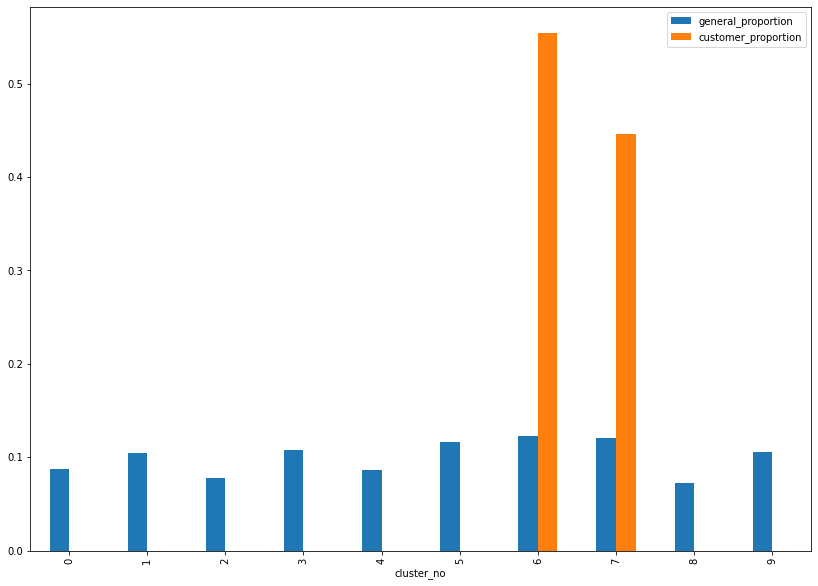

In [70]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

clusters_df = azdias_cleaned.predicted_cluster.value_counts().reset_index().merge(
    customers.predicted_cluster.value_counts().reset_index(),
    how='left', on='index')

clusters_df.columns=['cluster_no', 'general_proportion', 'customer_proportion']
clusters_df.general_proportion = clusters_df.general_proportion / len(azdias_cleaned)
clusters_df.customer_proportion = clusters_df.customer_proportion / len(customers)
clusters_df = clusters_df.sort_values(by='cluster_no')
clusters_df.plot(x='cluster_no', y=['general_proportion','customer_proportion'], kind='bar', figsize=(14,10))

In [58]:
# clusters_df.head().hist() #x='cluster_no', y=['general_proportion', 'customer_proportion']

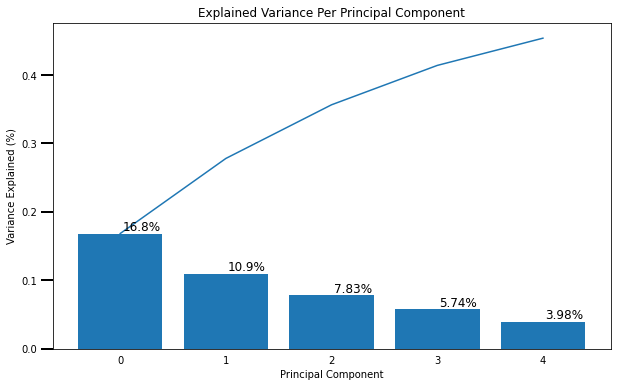

In [59]:
#Taken from Unsupervised Lesson 4
def do_pca(n_components, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
_, n_comps = grid_search_results['best_params'].values()
# pca, X_pca = do_pca (n_components=10, data=customers)
pca, X_pca = do_pca (n_components=n_comps, data=azdias_cleaned)
scree_plot(pca)

In [ ]:
# pd.DataFrame.from_dict(dict(zip(customers.columns,
#     pca.inverse_transform(cust_kms.km.cluster_centers_[14]))), orient='index').rename(
# columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)zΩ

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2,predicted_cluster
Dimension 1,0.1684,-0.0743,0.0154,0.0288,-0.1896,0.1030,-0.0731,0.0399,0.0430,0.1576,-0.0486,0.2020,0.1913,0.1891,0.0387,-0.1479,0.1265,0.1747,0.1196,0.1874,-0.1089,-0.0004
Dimension 2,0.1097,0.2717,0.0884,-0.1316,0.0981,-0.2509,0.2393,-0.2074,-0.2312,0.0871,0.1127,0.0497,0.0502,0.0465,0.0067,-0.0402,0.0400,0.0517,0.0383,0.0368,0.0215,-0.0297
Dimension 3,0.0784,0.0788,-0.3610,-0.0443,0.1559,-0.1061,0.0975,-0.1845,-0.1043,-0.0417,0.1197,0.0427,0.0460,0.0495,0.0022,-0.0401,0.0345,0.0423,0.0296,0.0284,-0.0095,-0.0292
Dimension 4,0.0575,0.0068,0.0153,0.0581,0.0300,-0.0158,0.0085,-0.0537,-0.0220,-0.0291,0.0418,0.1269,0.1317,0.1277,0.0220,-0.1012,0.0974,0.1784,0.1023,0.0215,-0.0122,-0.0457
Dimension 5,0.0398,0.0594,-0.0199,-0.0339,-0.0500,-0.0040,0.0234,0.1269,-0.0947,0.0883,0.0376,-0.0557,-0.0380,-0.0227,-0.1609,-0.0972,-0.0145,-0.2174,-0.0660,0.1738,-0.1021,0.0380


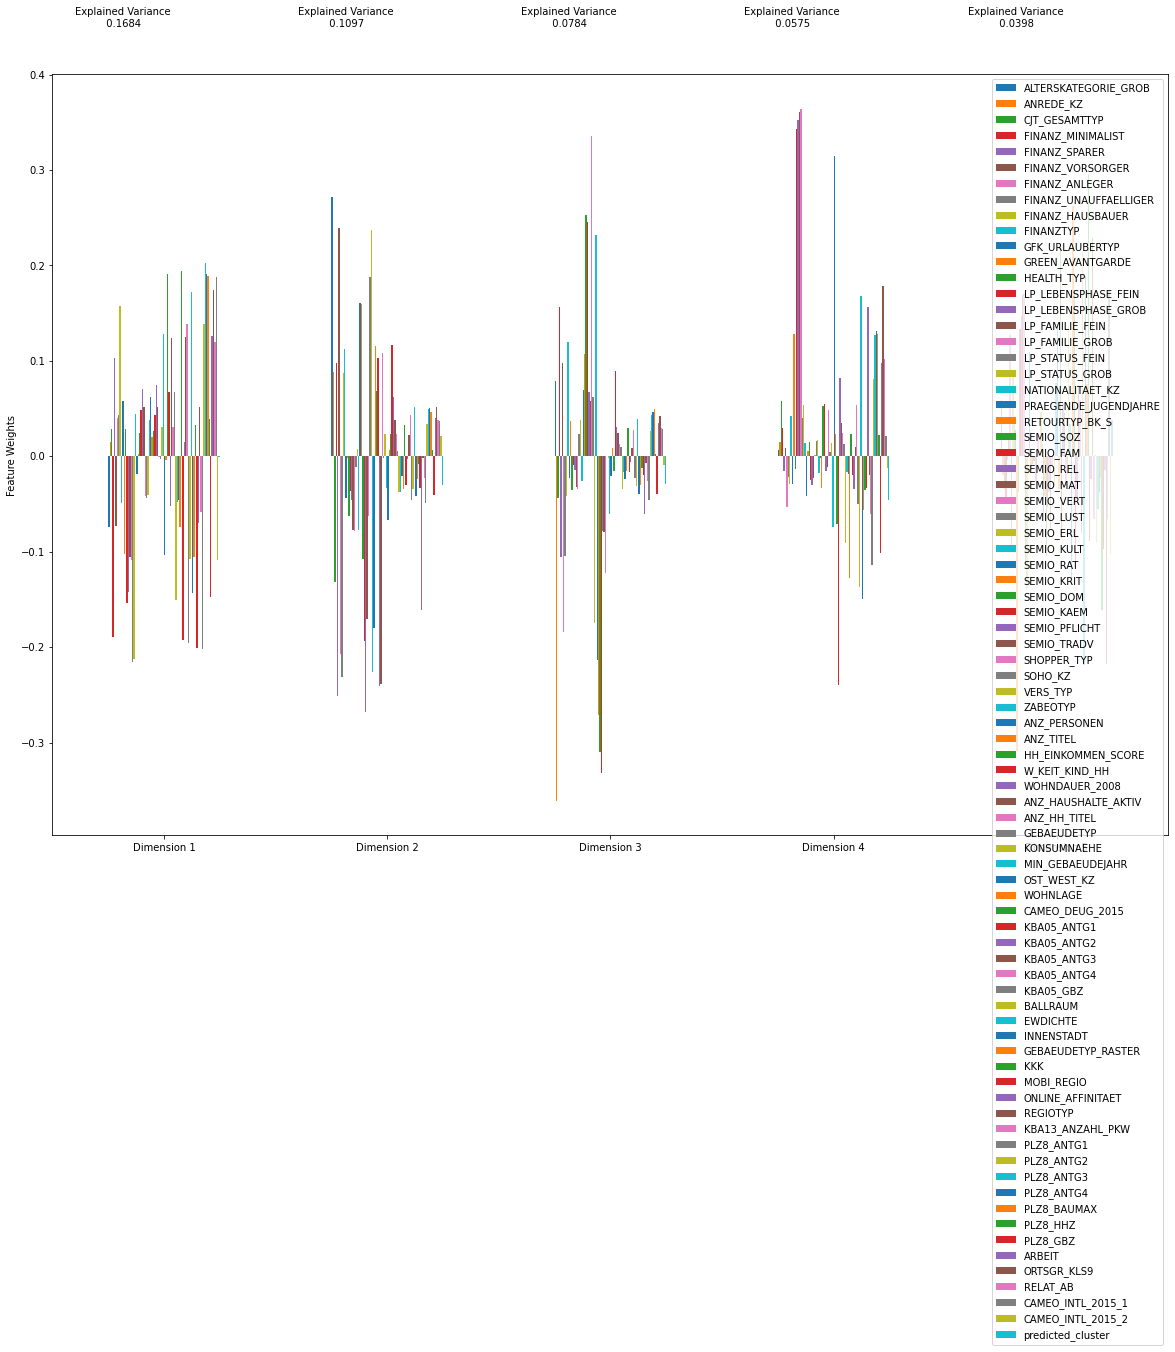

In [60]:
#Taken from Unsupervised Lesson 4
def pca_results(full_dataset, pca):
	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (20,14))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

pca_results(azdias_cleaned, pca)

In [61]:
#Taken from Unsupervised Lesson 4
def do_pca(n_components, data):
    X = scale_features(data).fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

def pca_results(full_dataset, pca):
	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

_, n_comps = grid_search_results['best_params'].values()
cpca, cX_pca = do_pca (n_components=n_comps, data=customers)
apca, aX_pca = do_pca (n_components=n_comps, data=azdias_cleaned)

In [62]:
def show_dim_diff(gen_df, cust_df, gen_pca, cust_pca, col):
    c = pca_results(cust_df, cust_pca).loc[col].reset_index()
    a = pca_results(gen_df, gen_pca).loc[col].reset_index()
    a.columns = ['Features', f'{col}(General)']
    c.columns = ['Features', f'{col}(Customer)']
    dim1 = pd.merge(a, c, on='Features')._to_pandas()
    dim1 = dim1.drop(0, axis=0)
    dim1 = dim1.drop(max(dim1.index), axis=0)
    del a, c
    # dim1[np.abs(dim1['Dimension 1(General)'] - dim1['Dimension 1(Customer)']) > .02]
    dim1['absolute_diff'] = np.abs(dim1[f'{col}(General)'] - dim1[f'{col}(Customer)'])
    df = dim1.sort_values(f'{col}(General)', ascending=False).head(n=10)
    display(df.style.background_gradient(cmap='Greens'))
    #TODO: Make graph to compare differences
    
for c in pca_results(customers, cpca).index:
    show_dim_diff(azdias_cleaned, customers, apca, cpca, c)
    

,Features,Dimension 1(General),Dimension 1(Customer),absolute_diff
70,PLZ8_ANTG3,0.202000,-0.000000,0.202000
53,CAMEO_DEUG_2015,0.193800,-0.000000,0.193800
71,PLZ8_ANTG4,0.191300,-0.000000,0.191300
43,HH_EINKOMMEN_SCORE,0.190700,-0.031900,0.222600
72,PLZ8_BAUMAX,0.189100,-0.000000,0.189100
78,CAMEO_INTL_2015_1,0.187400,-0.000000,0.187400
76,ORTSGR_KLS9,0.174700,-0.000000,0.174700
60,EWDICHTE,0.171900,-0.000000,0.171900
9,FINANZ_HAUSBAUER,0.157600,0.073100,0.084500
57,KBA05_ANTG4,0.138900,-0.000000,0.138900


,Features,Dimension 2(General),Dimension 2(Customer),absolute_diff
1,ALTERSKATEGORIE_GROB,0.271700,-0.162500,0.434200
6,FINANZ_VORSORGER,0.239300,-0.149600,0.388900
29,SEMIO_ERL,0.237400,-0.326800,0.564200
28,SEMIO_LUST,0.187400,-0.130700,0.318100
21,PRAEGENDE_JUGENDJAHRE,0.160300,0.000000,0.160300
22,RETOURTYP_BK_S,0.159000,-0.051700,0.210700
44,W_KEIT_KIND_HH,0.116800,0.000000,0.116800
32,SEMIO_KRIT,0.115800,-0.140600,0.256400
10,FINANZTYP,0.112700,0.042600,0.070100
37,SHOPPER_TYP,0.108400,0.000000,0.108400


,Features,Dimension 3(General),Dimension 3(Customer),absolute_diff
27,SEMIO_VERT,0.335700,0.110500,0.225200
23,SEMIO_SOZ,0.253300,0.124400,0.128900
24,SEMIO_FAM,0.245500,0.171500,0.074000
30,SEMIO_KULT,0.231800,0.174800,0.057000
4,FINANZ_MINIMALIST,0.155900,-0.234500,0.390400
10,FINANZTYP,0.119700,0.090300,0.029400
22,RETOURTYP_BK_S,0.106600,0.145000,0.038400
6,FINANZ_VORSORGER,0.097500,0.030300,0.067200
44,W_KEIT_KIND_HH,0.089400,-0.000000,0.089400
1,ALTERSKATEGORIE_GROB,0.078800,0.014800,0.064000


,Features,Dimension 4(General),Dimension 4(Customer),absolute_diff
17,LP_FAMILIE_GROB,0.364000,0.000000,0.364000
16,LP_FAMILIE_FEIN,0.361200,0.000000,0.361200
15,LP_LEBENSPHASE_GROB,0.352600,0.000000,0.352600
14,LP_LEBENSPHASE_FEIN,0.343400,-0.000000,0.343400
41,ANZ_PERSONEN,0.314200,0.000000,0.314200
76,ORTSGR_KLS9,0.178400,0.000000,0.178400
60,EWDICHTE,0.167900,0.000000,0.167900
65,ONLINE_AFFINITAET,0.156700,0.278500,0.121800
71,PLZ8_ANTG4,0.131700,0.000000,0.131700
12,GREEN_AVANTGARDE,0.128500,0.003500,0.125000


,Features,Dimension 5(General),Dimension 5(Customer),absolute_diff
63,KKK,0.295300,0.000000,0.295300
52,WOHNLAGE,0.261700,0.000000,0.261700
66,REGIOTYP,0.228700,0.000000,0.228700
43,HH_EINKOMMEN_SCORE,0.220200,0.183600,0.036600
59,BALLRAUM,0.215000,0.000000,0.215000
61,INNENSTADT,0.188800,0.000000,0.188800
78,CAMEO_INTL_2015_1,0.173800,0.000000,0.173800
53,CAMEO_DEUG_2015,0.173700,0.000000,0.173700
17,LP_FAMILIE_GROB,0.170400,0.000000,0.170400
16,LP_FAMILIE_FEIN,0.170000,0.000000,0.170000


In [68]:
# gmodel.steps[2][1].__dict__['cluster_centers_']

In [5]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
""" 
Dimension1 shows that financials, income levels, personality have the 
    largest differences between populations.
Dimensino2 shows that personality, age, financial type, have the largest differences.
Dimension3 shows that social status, financial type, household income,
    environmental sustainability alignment, energy consumption, gender, etc.. are the
    largest differences.
....
"""

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2
0,1.0,2,5.0,1,5,2,5,4,5,1,10.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,5.0,1.0
1,3.0,2,3.0,1,4,1,2,3,5,1,10.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,2.0,4.0
2,4.0,2,2.0,4,2,5,2,1,2,6,1.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1.0,2.0
3,3.0,1,5.0,4,3,4,1,3,2,5,5.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,3.0
4,1.0,2,2.0,3,1,5,2,2,5,2,1.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,5.0,4.0


### Discussion 3.3: Compare Customer Data to Demographics Data

I struggled mightily with the use of PCA for this analysis. I understand that 2 clusters in particular are heavily represented in the Customer population vs. the General population, but I struggle to align these clusters back through the dimensions to the features themselves. 

Similarly, I can grasp that certain variables account for the variance that segments the population, but I cannot understand the magnitude in a particular direction by any one variable - categorical variables in particular. I'd want to proceed with addition analysis such as regression analysis to parse out the strength of relationships that each variable has to a particular cluster and to isolate key features for marketing campaigns.


As was stated previously, I believe that PCA in particular is sub-optimal for the use-case of market segmentation. 

One critique of PCA is that is adds opacity to the analysis of feature importance. 

If the goal is prediction, then PCA may be necessary for better/more accuracte **predictions**. However, if the goal is **interpretability** then accuracy matters much less than understanding.

I would be VERY hard-pressed to explain the outcomes of these customer segments to a room full of Marketing executives and business stakeholders. 

Inversely, I would have no trouble implementing this for the basis of recommendations in a product such as an API called via a e-commerce web app. 



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.